In [8]:
import numpy as np
import tensorflow as tf
import cv2
import os
import itertools
import math
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import datetime

### Enumerate Input Image Files

In [9]:
#base_dir = '/media/MassStorage_WD/inbox/'
base_dir = '/media/MassStorage_WD/albums/'
capture_dir = '05-08-22_SunsetTimelapse/'
path = base_dir + capture_dir

frame_files = [f for f in listdir(path) if isfile(join(path, f))]
frame_files.sort()

def calc_duration(fps, num_frames):
    dur_secs = num_frames/fps
    res = datetime.timedelta(seconds =dur_secs)
    print(res)

In [10]:
calc_duration(fps=24, num_frames=len(frame_files))

0:00:26.250000


### Make a graph of change over time

In [5]:
diffs = []
diffs_smooth = []
diff_smooth = None
alpha = 0.25
img_last = None

for idx,file in enumerate(frame_files):
    filepath = path + file
    print(idx/len(frame_files), end='\r')
    img = cv2.imread(filepath).astype(np.float32)/255.0
    img = cv2.resize(img, (1080, 1920))
    if(img_last is not None):
        diffs += [np.sum(np.abs(img_last - img))]
        if(diff_smooth is None):
            diff_smooth = diffs[-1] 
        diff_smooth = diff_smooth*(1-alpha) + diffs[-1]*(alpha)
        diffs_smooth += [diff_smooth]
        
    img_last = img

13058.386963867188 (1282,)


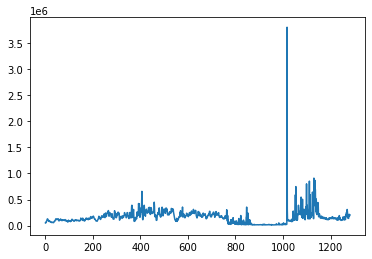

In [6]:
diffs = np.array(diffs)
# Generate the speed stats
vel_mean = np.mean(diffs)
vel_std = np.std(diffs)

dist_norm = (np.array(diffs)-vel_mean)/vel_std

outlier_prop = 0.1

outlier_limit = np.percentile(diffs, outlier_prop)

diffs_clean = diffs[diffs > outlier_limit]

print(outlier_limit, diffs_clean.shape)
plt.plot(diffs_clean)
plt.show()

## Plot histogram of deltas

NameError: name 'dist_norm' is not defined

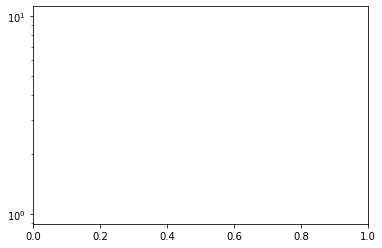

In [11]:
# Maximum frames squashed into 1 (speedup)
max_vel_scaling = 10
# Minimum speed 
min_vel_scaling = 1

plt.yscale('log')
plt.hist(np.array(dist_norm), bins=100)

plt.show()

## Process Images

In [44]:
fps = 24
frame_0 = cv2.imread(path+frame_files[0])
frame_width = int(1920*2)
frame_height = int(1080*2)
disp_scale = 0.2
write_video = False

if(write_video):
    out = cv2.VideoWriter(path+'timelapse2.avi', 
                          cv2.VideoWriter_fourcc('M','J','P','G'), 
                          fps, 
                          (frame_width,frame_height))
else:
    out_dir = './processed_images/'

# Generate video w/ zoom and dynamic time
init_crop_scale = 1.00
fin_crop_scale  = 0.50

# Buffer settings
mean_buff = []
buff_len = 1

def calc_crop_factor(idx, count):
    return (init_crop_scale-fin_crop_scale)*idx/count+fin_crop_scale

for idx,file in enumerate(frame_files):
    print(100*idx/len(frame_files), '%', end='\r')
    
    if(idx == 0):
        crop_factor = calc_crop_factor(idx, len(frame_files))
        
    try: 
        velocity = diffs[idx]
    except: 
        pass

    # Read the image file
    filepath = path + file
    img = cv2.imread(filepath).astype(np.float32)/255.0
    # Crop it and resize
    img = tf.image.central_crop(img, crop_factor)

    # Resize to display dimensions
    img = tf.image.resize(img, (frame_height, frame_width))
    
    mean_buff += [img]
    
    if(len(mean_buff) >= buff_len):
        img_out = tf.reduce_mean(tf.stack(mean_buff, axis=0), axis=0)
        img_out = (img_out*255.0).numpy().astype(np.uint8)

        if(write_video):
            out.write(img_out)
        else:
            img_save_path = out_dir+file
            ret = cv2.imwrite(img_save_path, img_out)
            if(not ret):
                print('ERROR: IMAGE SAVING FAILED', img_save_path, img_out.shape, img_out.dtype)
                break
        
        # Recalc crop_factor
        crop_factor = calc_crop_factor(idx, len(frame_files))
        # Display
        cv2.imshow('frame', cv2.resize(img_out, (int(disp_scale*img_out.shape[1]), int(disp_scale*img_out.shape[0]))))
        cv2.waitKey(1)
        
        mean_buff = []

if(write_video):
    out.release()

KeyboardInterrupt: 

In [94]:
out.release()

In [24]:
img_out = np.zeros((100, 200, 3), dtype=np.uint8)
ret = cv2.imwrite(img_save_path, img_out)
print(img_save_path, ret)

~/Downloads/processed_images/DSC02174.png False


In [41]:
disp_scale = 0.2
cv2.imshow('frame', cv2.resize(img_out, (int(disp_scale*img_out.shape[0]), int(disp_scale*img_out.shape[1]))))
cv2.waitKey(1)

106

In [27]:
cv2.imwrite('~/test.png', np.zeros((100,200,3)).astype(np.uint8))

False

In [ ]:
# https://shotkit.com/f-stop-chart/
def estimate_lux(img, shutter_speed, iso, fstop):
    base_iso = 100
    img_sum = tf.reduce_sum(img)
    
    shutter_speed*img_sum/iso
    

In [38]:
img_out.shape

(2160, 3840, 3)

In [39]:
cv2.resize(img_out, (int(disp_scale*img_out.shape[0]), int(disp_scale*img_out.shape[1]))).shape

(768, 432, 3)